# An comparison of clustering approaches to a sample of the Movies Dataset

The following cells contain the necessary preprocessing of the data followed by each approach, mostly differentiated by data encoding choices.

## Imports

In [1]:
# Download packages if necessary:

#!pip install kmodes
#!pip install scikit-learn

In [2]:
# SOME CONSTANTS [MUST DELETE BEFORE PUBLICATION]
MAX_INIT_TRIES = 10
RAISE_INIT_TRIES = 20
verbose = True

In [3]:
import os
import sys

In [4]:
current_dir = os.getcwd()

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

In [5]:
sys.path.append(parent_dir)

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from itertools import compress
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

Imports done.

## Data Preprocessing

In [6]:
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

In [7]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

From now on, we work with the columns that contain useful tabular information.  
We remove `budget, revenue and popularity` due to high prevalence of missing values.

In [8]:
movies_metadata = movies_metadata.loc[:,[
    'title', 'adult', 'genres', 'id', 'original_language',
    'production_companies', 'production_countries', 'release_date',
    'runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count'
]].set_index('id')

In [9]:
def zero_to_nan(value):
    try:
        if float(value) < 1 and float(value) > -1:
            return np.NaN
        else:
            return value
    except ValueError:
        print(value)
        return np.NaN

In [10]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [11]:
movies_metadata['runtime'] = movies_metadata['runtime'].apply(zero_to_nan)
print("1")
movies_metadata['vote_average'] = movies_metadata['vote_average'].apply(zero_to_nan)

1


In [12]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [13]:
movies_metadata.loc["461257",:].genres

'[]'

In [14]:
unpackable_cols = ('genres', 'production_companies', 'production_countries',
                   'spoken_languages')

for col in unpackable_cols:
    movies_metadata[col] = movies_metadata[col].apply(lambda x: np.NaN if x == '[]' else x)    

In [15]:
main_keys = {
    'genres':'name',
    'production_companies':'id',
    'production_countries':'iso_3166_1',
    'spoken_languages':'iso_639_1'
}

def unpack_list_of_dicts(value_list:str,        # organized like List[Dict[str, Any]]
                         main_key:str) -> set:
    out = []
    
    if not isinstance(value_list, str):
        return np.NaN

    clean_value_list = value_list[2:-2].replace(", {", "").split("}")

    for val in clean_value_list:
        sep_val = val.split(', ')
        main_key_mask = [main_key in e for e in sep_val]
        try:
            main_component = list(compress(sep_val, main_key_mask))[0]
        except IndexError:  # Weird cases with wrong typing
            return np.NaN
        clean_component = main_component.split(': ')[1].replace("'","")
        out.append(clean_component)
    return out 


for col in unpackable_cols:
    key = main_keys[col]  
    movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [16]:
for col in unpackable_cols:
    key = main_keys[col]
    movies_metadata[col] = movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [17]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,81.0,[en],Released,7.7,5415.0
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,104.0,"[en, fr]",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,101.0,[en],Released,6.5,92.0
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,127.0,[en],Released,6.1,34.0
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,106.0,[en],Released,5.7,173.0


Finally, for preprocessing, we scale the numerical variables to mitigate the influence of differently-scaled variables on the clustering.

In [18]:
scaler = MinMaxScaler()

movies_metadata[['runtime', 'vote_average', 'vote_count']] = scaler.fit_transform(movies_metadata[['runtime', 'vote_average', 'vote_count']])

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [19]:
movies_metadata.shape

(45466, 12)

In [20]:
movies_metadata['adult'] = movies_metadata.adult.apply(lambda x: 0 if x == "False" else 1)

In [21]:
analysis_columns = list(movies_metadata.columns)
analysis_columns.remove('title')
analysis_columns.remove('release_date')

analysis_columns

['adult',
 'genres',
 'original_language',
 'production_companies',
 'production_countries',
 'runtime',
 'spoken_languages',
 'status',
 'vote_average',
 'vote_count']

In [22]:
movies_metadata.dropna(inplace=True, subset=analysis_columns)
movies_metadata.shape

(30575, 12)

In [23]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata.release_date)

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,0,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,0,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,0,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,0,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,0,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Having to sample a subset for performance reasons, we first limit to 2000's movies to increase relevance and apparent similarity:

In [24]:
movies_metadata = movies_metadata[movies_metadata.release_date > '2000-01-01']

movies_metadata.shape

(15227, 12)

In [25]:
# We subsample to limit dataset size
movies_metadata.reset_index(drop=True, inplace=True)
movies_metadata = movies_metadata.sample(8000, random_state=42)

Done!

# Alternative Clustering Approaches

## Option 1: Treat any multi-valued categorical attribute value as a single value

This first option treats any multi-valued categorical variable as if they were single-valued categorical variables. This means that each attribute can have up to $\sum_{k=1}^{|L|} {{|L| \choose k}}$ possible levels. Models will treat each level orthogonally, even though they may contain values of the vocabulary $L$ in common.

In [26]:
option_1_df = movies_metadata.copy()

In [27]:
for col in unpackable_cols:
    option_1_df[col] = option_1_df[col].astype(str)

In [28]:
option_1_df.dtypes

title                           object
adult                            int64
genres                          object
original_language               object
production_companies            object
production_countries            object
release_date            datetime64[ns]
runtime                        float64
spoken_languages                object
status                          object
vote_average                   float64
vote_count                     float64
dtype: object

In [29]:
X = option_1_df.loc[:,analysis_columns]
X

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
8968,0,"['History', 'Drama']",fr,['83'],"['FR', 'IT']",0.125896,"['af', 'nl', 'en', 'fr']",Released,0.666667,0.002629
10795,0,['Comedy'],hi,['3939'],['IN'],0.112351,['hi'],Released,0.488889,0.001137
8239,0,['Documentary'],fr,['6841'],"['CH', 'FR', 'DE']",0.070916,['fr'],Released,0.777778,0.000213
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],0.070120,['en'],Released,0.633333,0.006323
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],0.073307,['pt'],Released,0.477778,0.000497
...,...,...,...,...,...,...,...,...,...,...
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],0.073307,"['en', 'ko']",Released,0.477778,0.040710
5092,0,['Comedy'],en,"['12', '771']",['US'],0.085259,['en'],Released,0.555556,0.023801
9402,0,"['Action', 'Comedy', 'Family']",en,"['5', '2608', '3045', '7431', '34034', '46222']",['US'],0.074104,['en'],Released,0.444444,0.040924
5377,0,"['Family', 'Animation']",ja,"['7092', 'Hokkaido Broadcasting Co.', '7094']",['JP'],0.078884,"['en', 'ja']",Released,0.733333,0.002984


In [30]:
# cat_cols = ['adult', 'genres', 'original_language', 'production_companies', 'production_countries', 'spoken_languages', 'status']
cat_cols = [0, 1, 2, 3, 4, 6, 7]

Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [31]:
kp = KPrototypes(n_clusters=4, verbose=True, init='Cao', random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...


Run: 1, iteration: 1/100, moves: 2606, ncost: 924.8018709892875
Run: 1, iteration: 2/100, moves: 1500, ncost: 918.6923543468556
Run: 1, iteration: 3/100, moves: 484, ncost: 918.35876047867
Run: 1, iteration: 4/100, moves: 125, ncost: 918.2857541315753
Run: 1, iteration: 5/100, moves: 147, ncost: 918.2318414901889
Run: 1, iteration: 6/100, moves: 46, ncost: 918.2284622637793
Run: 1, iteration: 7/100, moves: 7, ncost: 918.2284065386176
Run: 1, iteration: 8/100, moves: 3, ncost: 918.2284022145215
Run: 1, iteration: 9/100, moves: 0, ncost: 918.2284022145215
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3214, ncost: 917.0539656928966
Run: 2, iteration: 2/100, moves: 1193, ncost: 915.1852649059542
Run: 2, iteration: 3/100, moves: 300, ncost: 914.9347615686391
Run: 2, iteration: 4/100, moves: 90, ncost: 914.9156434453453
Run: 2, iteration: 5/100, moves: 31, ncost: 914.912658818698
Run: 2, iteration: 6/100, moves: 1, ncost: 914

In [32]:
print(kp.cluster_centroids_)

[['0.07968175943232246' '0.5572919833789391' '0.01486984711944161' '0'
  "['Drama']" 'en' "['2']" "['US']" "['en']" 'Released']
 ['0.08360733589753803' '0.5951774340309368' '0.004282595028259169' '0'
  "['Comedy']" 'fr' "['7819']" "['FR']" "['fr']" 'Released']
 ['0.08329521758864378' '0.696807925151351' '0.04144606249835026' '0'
  "['Documentary']" 'en' "['5996']" "['US']" "['en']" 'Released']
 ['0.0743060071690944' '0.38954503249767825' '0.004983529341915808' '0'
  "['Comedy']" 'en' "['1311']" "['US']" "['en']" 'Released']]


In [33]:
print(kp.cluster_centroids_[0])

['0.07968175943232246' '0.5572919833789391' '0.01486984711944161' '0'
 "['Drama']" 'en' "['2']" "['US']" "['en']" 'Released']


If we look at the cluster membership of the first cluster...

In [34]:
X[kp.labels_ == 0]

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],0.070120,['en'],Released,0.633333,0.006323
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],0.073307,['pt'],Released,0.477778,0.000497
2753,0,['Drama'],en,"['43', '2361', '10059', '23105', '67504']",['US'],0.090040,['en'],Released,0.644444,0.007957
10057,0,"['Drama', 'Thriller']",en,['35471'],['GB'],0.048606,['en'],Released,0.611111,0.007531
4110,0,"['Animation', 'Comedy', 'Family']",en,"['2', '12203']",['US'],0.056574,['en'],Released,0.555556,0.016554
...,...,...,...,...,...,...,...,...,...,...
328,0,"['Comedy', 'Romance']",en,['3287'],['US'],0.070916,['en'],Released,0.622222,0.001208
253,0,['Drama'],en,"['2291', '6847', '8857']",['US'],0.074900,"['es', 'en']",Released,0.600000,0.000497
8803,0,"['Comedy', 'Drama']",es,['16496'],"['MX', 'FR']",0.068526,['es'],Released,0.522222,0.001208
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],0.073307,"['en', 'ko']",Released,0.477778,0.040710


We can see, as expected, that the genres and the production companies have *nothing in common* with the centroid! Concordance is higher for the status, adult and genre attributes, which can be attributed to the higher frequency of the values taken in the centroids.

Every run took about 6 to 16 iterations to converge. To judge the quality of the clustering, we can use the Silhouette score.

Since the distance is a linear combination, we can compute the numeric distance matrix, then the categorical one, and sum them taking advantage of numpy's speed.

In [35]:
num_cols = [i for i in range(len(X.columns)) if i not in cat_cols]

In [36]:
for col_i in cat_cols:
    X.iloc[:,col_i] = X.iloc[:,col_i].astype(str)

C:\Users\manue\AppData\Local\Temp\ipykernel_2312\3025835097.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8968     0
10795    0
8239     0
14258    0
14059    0
        ..
6022     0
5092     0
9402     0
5377     0
3019     0
Name: adult, Length: 8000, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:,col_i] = X.iloc[:,col_i].astype(str)


In [37]:
X_cat = X.iloc[:,cat_cols]
X_num = X.iloc[:,num_cols]

In [38]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X_num.values)

In [39]:
X_cat

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
8968,0,"['History', 'Drama']",fr,['83'],"['FR', 'IT']","['af', 'nl', 'en', 'fr']",Released
10795,0,['Comedy'],hi,['3939'],['IN'],['hi'],Released
8239,0,['Documentary'],fr,['6841'],"['CH', 'FR', 'DE']",['fr'],Released
14258,0,['Drama'],en,"['288', '7281', '64479', '74150', '92473', '92...",['GB'],['en'],Released
14059,0,['Drama'],pt,"['8680', '16418', '26019']",['PT'],['pt'],Released
...,...,...,...,...,...,...,...
6022,0,"['War', 'Action', 'Thriller', 'Science Fiction']",en,"['1836', '7263']",['US'],"['en', 'ko']",Released
5092,0,['Comedy'],en,"['12', '771']",['US'],['en'],Released
9402,0,"['Action', 'Comedy', 'Family']",en,"['5', '2608', '3045', '7431', '34034', '46222']",['US'],['en'],Released
5377,0,"['Family', 'Animation']",ja,"['7092', 'Hokkaido Broadcasting Co.', '7094']",['JP'],"['en', 'ja']",Released


In [40]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat.loc[:,col] = cat_enc.fit_transform(X_cat.loc[:,col])

    cat_encoders[col] = cat_enc

In [41]:
X_cat.head()

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
8968,0,1084,19,6338,472,4,3
10795,0,622,21,3624,632,607,3
8239,0,713,19,5398,191,583,3
14258,0,920,14,2530,564,484,3
14059,0,920,48,6518,812,740,3


In [42]:
for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype(int)

C:\Users\manue\AppData\Local\Temp\ipykernel_2312\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].astype(int)
C:\Users\manue\AppData\Local\Temp\ipykernel_2312\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].astype(int)
C:\Users\manue\AppData\Local\Temp\ipykernel_2312\1447058658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [43]:
X_cat.dtypes

adult                   int32
genres                  int32
original_language       int32
production_companies    int32
production_countries    int32
spoken_languages        int32
status                  int32
dtype: object

In [44]:
distance_matrix_cat = pdist(X_cat.values, 'hamming')

In [45]:
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [46]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.090302,1
1,-0.175448,3
2,-0.279497,1
3,-0.177053,0
4,0.069135,0


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto

<Axes: xlabel='silhouette_values', ylabel='Count'>

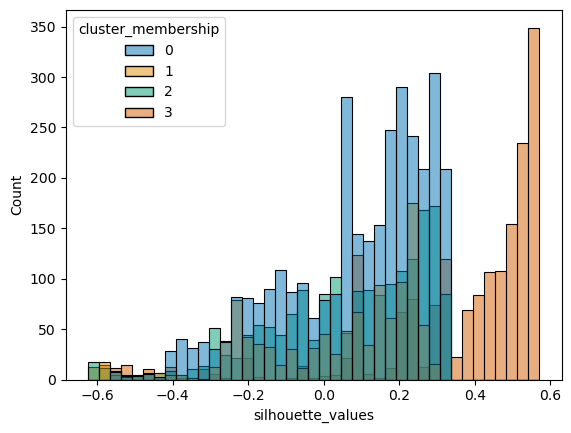

In [47]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [48]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.13107432726085186


Having established the process, we can choose an optimal K based on the silhouette scores, and judge each approach based on its optimal cluster arrangement. **Whether the output clusterings are any good**, however, is to be judged *a posteriori*.

In [49]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_cols)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1591, ncost: 976.4389483471957
Run: 1, iteration: 2/100, moves: 725, ncost: 973.7954640816566
Run: 1, iteration: 3/100, moves: 257, ncost: 973.4949747414615
Run: 1, iteration: 4/100, moves: 131, ncost: 973.412814640038
Run: 1, iteration: 5/100, moves: 3, ncost: 973.412761011253
Run: 1, iteration: 6/100, moves: 0, ncost: 973.412761011253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 614, ncost: 1013.4066122050334
Run: 2, iteration: 2/100, moves: 33, ncost: 1013.4034536355751
Run: 2, iteration: 3/100, moves: 1, ncost: 1013.4033369198992
Run: 2, iteration: 4/100, moves: 0, ncost: 1013.4033369198992
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 240, ncost: 1012.0984510518188
Run: 3, iteration: 2/100, moves: 83, ncost: 1012.0375452725768
Run: 3, it

In [50]:
scores_dict

{'2': 0.38692787748789065,
 '3': 0.10698093999705256,
 '4': 0.13107432726085186,
 '5': 0.0874242411590957}

Higher is better (Rousseeuw, 1986), so we settle for two clusters. 

In [51]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1591, ncost: 976.4389483471957
Run: 1, iteration: 2/100, moves: 725, ncost: 973.7954640816566
Run: 1, iteration: 3/100, moves: 257, ncost: 973.4949747414615
Run: 1, iteration: 4/100, moves: 131, ncost: 973.412814640038
Run: 1, iteration: 5/100, moves: 3, ncost: 973.412761011253
Run: 1, iteration: 6/100, moves: 0, ncost: 973.412761011253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 614, ncost: 1013.4066122050334
Run: 2, iteration: 2/100, moves: 33, ncost: 1013.4034536355751
Run: 2, iteration: 3/100, moves: 1, ncost: 1013.4033369198992
Run: 2, iteration: 4/100, moves: 0, ncost: 1013.4033369198992
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 240, ncost: 1012.0984510518188
Run: 3, iteration: 2/100, moves: 83, ncost: 1012.0375452725768
Run: 3, it

In [52]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.513646,0
1,0.392371,1
2,0.484851,0
3,0.534756,0
4,-0.483099,0


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='silhouette_values', ylabel='Count'>

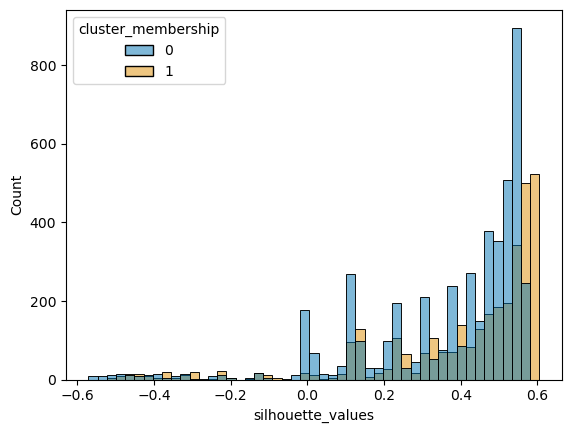

In [53]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [54]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.38692787748789065


In [55]:
# We add cluster membership to the original dataframe to keep track.

movies_metadata['membership_1'] = kp.labels_

Some points in the left tail seem to indicate undesirable clustering, but the general concentration of points in the right indicates that the clusters are differentiated to an agreeable degree.

In [56]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X_num.columns)+list(X_cat.columns))

In [57]:
centroid_df.loc[:,X_num.columns] = scaler.inverse_transform(centroid_df[X_num.columns])

In [58]:
centroid_df

,runtime,vote_average,vote_count,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
0,104.486595,6.717986,335.297657,0,['Drama'],en,['7036'],['US'],['en'],Released
1,96.413117,4.979528,107.926755,0,['Comedy'],en,['1311'],['US'],['en'],Released


In [59]:
X.groupby('genres').count()['adult'].sort_values(ascending=False).head()

genres
['Drama']               973
['Comedy']              609
['Documentary']         371
['Drama', 'Romance']    249
['Comedy', 'Drama']     239
Name: adult, dtype: int64

In [60]:
X.groupby('original_language').count()['adult'].sort_values(ascending=False).head()

original_language
en    5430
fr     512
ja     252
es     213
de     208
Name: adult, dtype: int64

In [61]:
X.groupby('production_companies').count()['adult'].sort_values(ascending=False).head()

production_companies
['2']       20
['7036']    20
['1311']    19
['12']      17
['33']      15
Name: adult, dtype: int64

As expected, the most common categories dominate the cluster centroids with an utter disregard for the contents of the multi-valued categorical attributes.

## Option 2: Apply Multi-Label Binarization. One-hot-encoding across values of all multi-valued attributes.

We may create up to $\sum_{x=1}^{m}{|L|}$ new attributes in the process if all possible levels of the vocabulary are present. If a given clustering is to be re-used for unseen observations, practicioners should be mindful of previously unseen values of the attributes' vocabulary. If no sample containing the complete dictionaries can be assembled, clusters should be fit on the maximum amount of attributes, even if some are empty as a result.

In [62]:
option_2_df = movies_metadata.copy()

In [63]:
option_2_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,membership_1
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629,0
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137,1
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213,0
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323,0
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497,0


In [64]:
option_2_df.index.rename('index', inplace=True)

### 2.1 Data Preparation

In [65]:
columns_to_concat = [option_2_df]
dummy_cols = []
multi_val_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for attribute in multi_val_cols:
    dummy_df = pd.get_dummies(option_2_df[attribute].apply(pd.Series).stack()).groupby('index', level=0).sum()
    dummy_cols += list(dummy_df.columns)
    columns_to_concat.append(dummy_df)

In [66]:
option_2_df = pd.concat(columns_to_concat, axis=1).drop(multi_val_cols, axis=1)

option_2_df.shape

(8000, 10126)

This approach to clustering multi-valued categorical attributes generates an explosive amount of columns. Common practice involves dropping uncommon labels, at the cost of losing sensitivity to anomalies.

In [67]:
frequencies = pd.DataFrame(option_2_df[dummy_cols].mean(), columns=['freq']).sort_values('freq')

frequencies

,freq
4259,0.000125
54268,0.000125
54259,0.000125
54245,0.000125
54238,0.000125
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [68]:
frequencies[frequencies.freq >= 0.005]

,freq
HU,0.005000
ta,0.005125
43,0.005125
el,0.005125
14,0.005250
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [69]:
saved_dummies = list(frequencies[frequencies.freq >= 0.005].index)

saved_cols = ['title', 'adult', 'original_language', 'release_date', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

88 rows labels with a frequency of at least 0.5% will be saved.

In [70]:
option_2_df = option_2_df.loc[:,saved_cols]

option_2_df.shape

(8000, 110)

In [71]:
attributes = ['adult', 'original_language', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

X = option_2_df.loc[:, attributes]

X.head()

,adult,original_language,runtime,status,vote_average,vote_count,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
index,,,,,,,,,,,,,,,,,,,,,
8968,0,fr,0.125896,Released,0.666667,0.002629,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
10795,0,hi,0.112351,Released,0.488889,0.001137,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8239,0,fr,0.070916,Released,0.777778,0.000213,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
14258,0,en,0.070120,Released,0.633333,0.006323,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14059,0,pt,0.073307,Released,0.477778,0.000497,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [72]:
cat_encoders = dict()
cat_cols = ['adult', 'original_language', 'status']

for col in X.columns:
    if col in cat_cols:
        cat_enc = LabelEncoder()
        X[col] = cat_enc.fit_transform(X.loc[:,col])

        cat_encoders[col] = cat_enc

### 2.2 Clustering

We start by using the silhouette technique to find an optimal k.

In [73]:
cat_col_indexes = [i for i in range(len(X.columns)) if X.columns[i] in (cat_cols + dummy_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(X.columns)))
        )
    )

In [74]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X.iloc[:, num_col_indexes].values)
distance_matrix_cat = pdist(X.iloc[:, cat_col_indexes].values, 'hamming')
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [75]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_col_indexes)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.1398858279986
Run: 3, iteration: 4/100, moves: 0, ncost: 1302.1398858279986
Init:

In [76]:
scores_dict

{'2': 0.041903974132294304,
 '3': -0.08908649484634068,
 '4': -0.05268306368045357,
 '5': -0.08304994791691438}

The dimensionality leads to no good clustering solution existing.

In [77]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_col_indexes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.1398858279986
Run: 3, iteration: 4/100, moves: 0, ncost: 1302.1398858279986
Init:

### 2.3 Evaluation

In [78]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.359602,1
1,-0.074028,1
2,0.286553,1
3,0.364772,1
4,-0.131227,1


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='silhouette_values', ylabel='Count'>

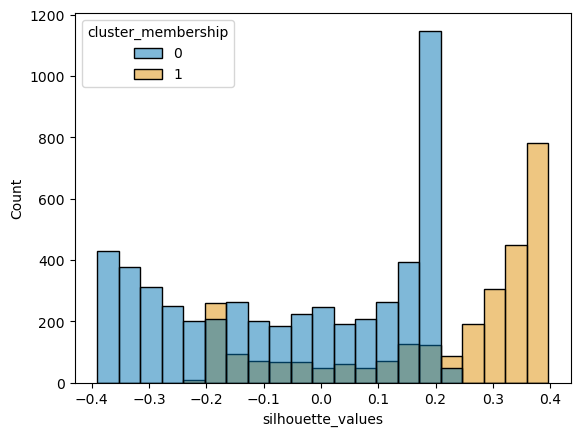

In [79]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [80]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.041903974132294304


In [81]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X.columns[num_col_indexes])+list(X.columns[cat_col_indexes]))
centroid_df.head()

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,0.077149,0.531915,0.024344,0.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.084679,0.600958,0.004413,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [82]:
num_cols = X.columns[num_col_indexes]

centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [83]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,97.822581,5.787233,342.637777,0.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [84]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [85]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,97.822581,5.787233,342.637777,0,en,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,0,fr,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Fairly close runtimes and vote averages. Both are not differentiated by being adult nor by status. Original language is a differentiating characteristic now.

In [86]:
criteria = centroid_df.iloc[0,:] != centroid_df.iloc[1,:]

criteria

runtime               True
vote_average          True
vote_count            True
adult                False
original_language     True
                     ...  
Thriller             False
Comedy               False
Drama                 True
US                    True
en                    True
Length: 108, dtype: bool

In [87]:
centroid_df[criteria.index[criteria]]

,runtime,vote_average,vote_count,original_language,Drama,US,en
0,97.822581,5.787233,342.637777,en,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,fr,1.0,0.0,0.0


We can see that the categorical differentiators are wether the genre is Drama, wether it was produced in the US, and whether English is spoken in the movie or not. Common appearance of certain characteristics seems to not have influenced cluster assignment.

In [88]:
# We add cluster membership to the original dataframe to keep track.

movies_metadata['membership_2'] = kp.labels_

Done!

## Option 3: Add PCA to Option 2 to reduce dimensionality and sparsity.

The main drawback is that adding PCA to the preprocessing reduces generality inasmuch as the principal components may vary with subsamples of the data and entails a loss of interpretability.

In [144]:
option_3_df = movies_metadata.copy()

In [145]:
option_3_df.index.rename('index', inplace=True)

option_3_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,membership_1,membership_2
index,,,,,,,,,,,,,,
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629,0,1
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137,1,1
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213,0,1
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323,0,1
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497,0,1


In [146]:
columns_to_concat = [option_3_df]
dummy_cols = []
multi_val_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for attribute in multi_val_cols:
    dummy_df = pd.get_dummies(option_3_df[attribute].apply(pd.Series).stack()).groupby('index', level=0).sum()
    dummy_cols += list(dummy_df.columns)
    columns_to_concat.append(dummy_df)

In [147]:
option_3_df = pd.concat(columns_to_concat, axis=1).drop(multi_val_cols, axis=1)

option_3_df.shape

(8000, 10127)

In [148]:
num_cols = ['runtime', 'vote_average', 'vote_count']
cat_cols = ['adult', 'original_language', 'status']

In [149]:
print(num_cols)
print(cat_cols)

['runtime', 'vote_average', 'vote_count']
['adult', 'original_language', 'status']


In [150]:
try:
    X = option_3_df.drop(['title', 'release_date', 'membership_1', 'membership_2'], axis=1)
except KeyError:
    X = option_3_df.drop(['title', 'release_date'], axis=1)

dummy_cols = list(
    set(X.columns).symmetric_difference(set(num_cols+cat_cols))
)

In [151]:
X.head()

,adult,original_language,runtime,status,vote_average,vote_count,Action,Adventure,Animation,Comedy,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
index,,,,,,,,,,,,,,,,,,,,,
8968,0,fr,0.125896,Released,0.666667,0.002629,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10795,0,hi,0.112351,Released,0.488889,0.001137,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8239,0,fr,0.070916,Released,0.777778,0.000213,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14258,0,en,0.070120,Released,0.633333,0.006323,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14059,0,pt,0.073307,Released,0.477778,0.000497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1 Data Preparation

In [152]:
X_num = X[num_cols]
X_cat = X[cat_cols]
X_dummies = X[dummy_cols]

#### 3.1.1 Numerical Attributes

In [153]:
# Already scaled at the top section. 

# numerical_scaler = MinMaxScaler()

# X_num = pd.DataFrame(numerical_scaler.fit_transform(X_num.values),
#                      columns=X_num.columns,
#                      index=X_num.index)

In [154]:
X_num.head()

,runtime,vote_average,vote_count
index,,,
8968,0.125896,0.666667,0.002629
10795,0.112351,0.488889,0.001137
8239,0.070916,0.777778,0.000213
14258,0.070120,0.633333,0.006323
14059,0.073307,0.477778,0.000497


#### 3.1.2 Categorical Attributes

In [155]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat[col] = cat_enc.fit_transform(X.loc[:,col])

    cat_encoders[col] = cat_enc

C:\Users\manue\AppData\Local\Temp\ipykernel_2312\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_2312\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_2312\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [156]:
X_cat.head()

,adult,original_language,status
index,,,
8968,0,19,3
10795,0,21,3
8239,0,19,3
14258,0,14,3
14059,0,48,3


#### 3.1.3 Multi-valued attributes/dummies

In [157]:
X_dummies

,2092,90636,736,39004,80676,21845,16659,5729,22539,81974,...,11462,4451,19090,22028,2382,22339,64599,12087,Celluloid Dreams,11008
index,,,,,,,,,,,,,,,,,,,,,
8968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to use Minka's MLE, we need more samples than features. Aiming at a 5-to-1 ratio, this means preserving the 1600 most-populated dummies.

In [158]:
frequencies = pd.DataFrame(X_dummies.mean(), columns=['freq']).sort_values('freq', ascending=False)
frequencies

,freq
en,0.697125
US,0.521250
Drama,0.494875
Comedy,0.305750
Thriller,0.233250
...,...
32667,0.000125
60030,0.000125
25713,0.000125
22195,0.000125


In [159]:
saved_dummies = list(frequencies.iloc[:1600].index)

In [160]:
saved_dummies = list(frequencies.iloc[:1600].index)

saved_cols = saved_dummies
X_dummies = X_dummies.loc[:,saved_cols]

X_dummies.shape

(8000, 1600)

In [161]:
# Update the list
dummy_cols = X_dummies.columns

Having repeated the process in Option 2, we add a PCA step using Minka's MLE (2000) for an automatic choice of dimensionality.

PCA will take a long time.

In [162]:
from sklearn.decomposition import PCA
import datetime as dt

In [163]:
X_dummies.shape

(8000, 1600)

#### 3.1.4 Principal Component Analysis

PCA's computational complexity is exponential (about $O(p^2n+p^3)$), so testing varying amounts of features is valuable to estimate runtime.

In [164]:
execution_time = []

for d in [50, 100, 150, 200, 300, 400, 500]:
    start = dt.datetime.now()
    PCA(
        n_components='mle',
        whiten=True     # Vectors are scaled to unit variance so that we can use them as numeric attributes
    ).fit_transform(X_dummies.iloc[:,:d])
    end = dt.datetime.now()
    execution_time.append((end-start).total_seconds())

c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

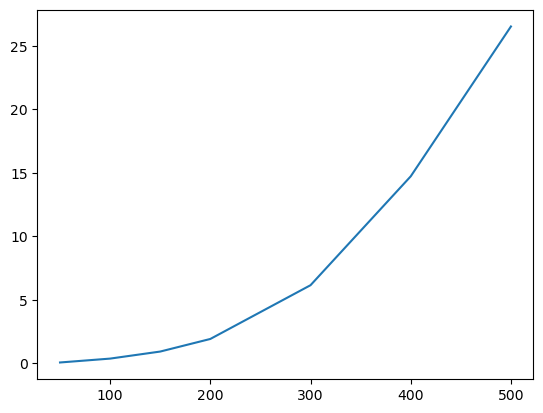

In [165]:
import seaborn as sns

sns.lineplot(x=[50, 100, 150, 200, 300, 400, 500], y=execution_time)

Using all the 1600 features should entail around $11.56\times$ the number of operations. 

In [166]:
p = 400
n = X.shape[0]
new_p = 500

expected_multiplier = (
        ((new_p**2) * n) + (new_p**3)
    )/(
        ((p**2) * n) + (p**3)
    )
print(f'Expected multiplier: {expected_multiplier}')

print(execution_time[-2]*expected_multiplier)
print(execution_time[-1])

Expected multiplier: 1.5811011904761905
23.27070582217262
26.511958


The calculation has some margin of error due to overhead. Let's extrapolate:

In [167]:
p = 500
n = X_dummies.shape[0]
new_p = X_dummies.shape[1]

expected_multiplier = (
        ((new_p**2) * n) + (new_p**3)
    )/(
        ((p**2) * n) + (p**3)
    )
print(f'Expected multiplier: {expected_multiplier}')

print(f"{execution_time[-1]*expected_multiplier / 60} minutes")

Expected multiplier: 11.565176470588236
5.110257880847059 minutes


We can expect the PCA for the totality of dummies to take about 12 times more time than for 500 dummies.

### 3.2.1 Clustering with MLE PCA

In [168]:
start = dt.datetime.now()

pca = PCA(
    n_components='mle',
    whiten=True     # Vectors are scaled to unit variance so that we can use them as numeric attributes
    )  

X_reduced_dummies = pca.fit_transform(X_dummies)

end = dt.datetime.now()

In [169]:
delta = end - start
print(f"Time difference is {delta.total_seconds()/60} minutes.")

Time difference is 14.997549766666667 minutes.


In [170]:
X_reduced_dummies.shape

(8000, 1597)

In [171]:
pca_cols = [f'component_'+str(col) for col in range(X_reduced_dummies.shape[1])]

X_reduced_dummies = pd.DataFrame(X_reduced_dummies, columns=pca_cols, index=X.index)

In [172]:
X_reduced_dummies.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
index,,,,,,,,,,,,,,,,,,,,,
8968,1.201175,0.394703,-0.819090,-1.661411,-0.721423,2.362566,-0.081968,-0.106717,0.233450,0.334306,...,0.093636,0.446063,0.239666,-0.002646,-0.637975,-0.174067,-0.880152,0.993532,-0.216550,0.245487
10795,0.914265,-1.460022,1.231641,0.308616,0.573048,-1.260486,-0.175146,-0.580800,-0.346147,-0.075187,...,-0.075058,0.009479,0.245371,0.036637,-0.025575,-0.039739,0.070507,-0.080255,-0.028007,0.096117
8239,1.411847,-0.250859,1.285492,-2.084359,-1.623985,1.799521,-0.531670,-0.481436,-1.782626,0.632553,...,-0.110928,-0.135218,0.008501,0.032479,-0.311243,-0.607447,-0.035790,-0.061408,0.025087,-0.392126
14258,0.516220,0.549301,-0.959559,-0.133562,-0.873229,-0.279711,2.520461,-0.954140,0.817663,-0.196683,...,-0.452931,-1.638832,1.144008,-0.150750,0.379856,0.036221,0.338750,0.939054,-0.059073,-0.168450
14059,1.368371,0.309210,-0.285194,0.611423,-0.735179,-0.837302,-0.625988,-0.383244,0.046417,0.082140,...,-0.062228,0.057695,-0.165154,0.063427,-0.000079,0.116737,0.366404,-0.225131,0.172220,-0.233006


In [173]:
mle_X = pd.concat([X_num, X_cat, X_reduced_dummies], axis=1)

print(mle_X.shape)

mle_X.head()

(8000, 1603)


,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
index,,,,,,,,,,,,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,19,3,1.201175,0.394703,-0.819090,-1.661411,...,0.093636,0.446063,0.239666,-0.002646,-0.637975,-0.174067,-0.880152,0.993532,-0.216550,0.245487
10795,0.112351,0.488889,0.001137,0,21,3,0.914265,-1.460022,1.231641,0.308616,...,-0.075058,0.009479,0.245371,0.036637,-0.025575,-0.039739,0.070507,-0.080255,-0.028007,0.096117
8239,0.070916,0.777778,0.000213,0,19,3,1.411847,-0.250859,1.285492,-2.084359,...,-0.110928,-0.135218,0.008501,0.032479,-0.311243,-0.607447,-0.035790,-0.061408,0.025087,-0.392126
14258,0.070120,0.633333,0.006323,0,14,3,0.516220,0.549301,-0.959559,-0.133562,...,-0.452931,-1.638832,1.144008,-0.150750,0.379856,0.036221,0.338750,0.939054,-0.059073,-0.168450
14059,0.073307,0.477778,0.000497,0,48,3,1.368371,0.309210,-0.285194,0.611423,...,-0.062228,0.057695,-0.165154,0.063427,-0.000079,0.116737,0.366404,-0.225131,0.172220,-0.233006


Let's cluster now.

In [174]:
cat_col_indexes = [i for i in range(len(mle_X.columns)) if mle_X.columns[i] in (cat_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(mle_X.columns)))
        )
    )

In [175]:
# K-Prototype uses the squared euclidean to avoid the square root operation

mle_distance_matrix_num = pdist(mle_X.iloc[:, num_col_indexes].values)
mle_distance_matrix_cat = pdist(mle_X.iloc[:, cat_col_indexes].values, 'hamming')

In [176]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(mle_X, categorical=cat_col_indexes)
    
    mle_distance_matrix = squareform(mle_distance_matrix_cat*kp.gamma + mle_distance_matrix_num)
    score=silhouette_score(mle_distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 219, ncost: 12768907.137011634
Run: 1, iteration: 2/100, moves: 54, ncost: 12768774.065513337
Run: 1, iteration: 3/100, moves: 13, ncost: 12768741.023123208
Run: 1, iteration: 4/100, moves: 12, ncost: 12768710.107477497
Run: 1, iteration: 5/100, moves: 0, ncost: 12768710.107477497
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 301, ncost: 12768865.649292383
Run: 2, iteration: 2/100, moves: 80, ncost: 12768722.71068161
Run: 2, iteration: 3/100, moves: 23, ncost: 12768683.662758945
Run: 2, iteration: 4/100, moves: 9, ncost: 12768666.57587003
Run: 2, iteration: 5/100, moves: 8, ncost: 12768646.436994642
Run: 2, iteration: 6/100, moves: 5, ncost: 12768635.363693161
Run: 2, iteration: 7/100, moves: 1, ncost: 12768632.831396243
Run: 2, iteration: 8/100, moves: 0, ncost: 12768632.831396243
Init: initializing centroid

In [177]:
scores_dict

{'2': 0.17093427614669576,
 '3': 0.14230859455203732,
 '4': 0.1382395587673687,
 '5': 0.08613573573571057}

In [199]:
mle_kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
mle_labels = mle_kp.fit_predict(mle_X, categorical=cat_col_indexes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 219, ncost: 12768907.137011634
Run: 1, iteration: 2/100, moves: 54, ncost: 12768774.065513337
Run: 1, iteration: 3/100, moves: 13, ncost: 12768741.023123208
Run: 1, iteration: 4/100, moves: 12, ncost: 12768710.107477497
Run: 1, iteration: 5/100, moves: 0, ncost: 12768710.107477497
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 301, ncost: 12768865.649292383
Run: 2, iteration: 2/100, moves: 80, ncost: 12768722.71068161
Run: 2, iteration: 3/100, moves: 23, ncost: 12768683.662758945
Run: 2, iteration: 4/100, moves: 9, ncost: 12768666.57587003
Run: 2, iteration: 5/100, moves: 8, ncost: 12768646.436994642
Run: 2, iteration: 6/100, moves: 5, ncost: 12768635.363693161
Run: 2, iteration: 7/100, moves: 1, ncost: 12768632.831396243
Run: 2, iteration: 8/100, moves: 0, ncost: 12768632.831396243
Init: initializing centroid

### 3.2.2 Clustering with $1/4$ of dummies as components only

In [179]:
start = dt.datetime.now()

pca = PCA(
    n_components=int(X_dummies.shape[1]/4),
    whiten=True
    )  

X_reduced_dummies = pca.fit_transform(X_dummies)

end = dt.datetime.now()

In [180]:
delta = end - start
time = delta.total_seconds()

if time < 100:
    print(f"Time difference is {time} seconds.")
else:
    print(f"Time difference is {delta.total_seconds()/60} minutes.")

Time difference is 1.943998 seconds.


In [181]:
X_reduced_dummies.shape

(8000, 400)

In [182]:
pca_cols = [f'component_'+str(col) for col in range(X_reduced_dummies.shape[1])]

X_reduced_dummies = pd.DataFrame(X_reduced_dummies, columns=pca_cols, index=X_dummies.index)

In [183]:
X_reduced_dummies.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399
index,,,,,,,,,,,,,,,,,,,,,
8968,1.201175,0.394703,-0.819090,-1.661411,-0.721423,2.362566,-0.081968,-0.106717,0.233450,0.334306,...,0.362427,1.649276,-0.378678,-1.754739,1.488098,0.122710,0.448600,0.181587,1.770652,-0.813553
10795,0.914265,-1.460022,1.231641,0.308616,0.573048,-1.260486,-0.175146,-0.580800,-0.346147,-0.075187,...,0.182068,0.110598,-0.103412,0.131516,-0.278970,0.095549,0.189444,-0.170792,-0.129916,0.080257
8239,1.411847,-0.250859,1.285492,-2.084359,-1.623985,1.799521,-0.531670,-0.481436,-1.782626,0.632553,...,-0.066151,-0.102532,-0.059840,-0.079651,-0.433613,0.078291,0.461555,0.156613,-0.188466,-0.077457
14258,0.516220,0.549301,-0.959559,-0.133562,-0.873229,-0.279711,2.520461,-0.954140,0.817663,-0.196683,...,-0.789924,0.242390,0.780975,0.015451,0.726151,-0.491239,0.252439,-0.468119,-0.039659,-0.498012
14059,1.368371,0.309210,-0.285194,0.611423,-0.735179,-0.837302,-0.625988,-0.383244,0.046417,0.082140,...,0.036751,0.116404,-0.010806,-0.293345,-0.294227,-0.078345,0.142706,0.198401,-0.327597,0.159758


In [184]:
heur_X = pd.concat([X_num, X_cat, X_reduced_dummies], axis=1)

heur_X.head()

,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_390,component_391,component_392,component_393,component_394,component_395,component_396,component_397,component_398,component_399
index,,,,,,,,,,,,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,19,3,1.201175,0.394703,-0.819090,-1.661411,...,0.362427,1.649276,-0.378678,-1.754739,1.488098,0.122710,0.448600,0.181587,1.770652,-0.813553
10795,0.112351,0.488889,0.001137,0,21,3,0.914265,-1.460022,1.231641,0.308616,...,0.182068,0.110598,-0.103412,0.131516,-0.278970,0.095549,0.189444,-0.170792,-0.129916,0.080257
8239,0.070916,0.777778,0.000213,0,19,3,1.411847,-0.250859,1.285492,-2.084359,...,-0.066151,-0.102532,-0.059840,-0.079651,-0.433613,0.078291,0.461555,0.156613,-0.188466,-0.077457
14258,0.070120,0.633333,0.006323,0,14,3,0.516220,0.549301,-0.959559,-0.133562,...,-0.789924,0.242390,0.780975,0.015451,0.726151,-0.491239,0.252439,-0.468119,-0.039659,-0.498012
14059,0.073307,0.477778,0.000497,0,48,3,1.368371,0.309210,-0.285194,0.611423,...,0.036751,0.116404,-0.010806,-0.293345,-0.294227,-0.078345,0.142706,0.198401,-0.327597,0.159758


Let's cluster now.

In [185]:
cat_col_indexes = [i for i in range(len(heur_X.columns)) if heur_X.columns[i] in (cat_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(heur_X.columns)))
        )
    )

In [186]:
# K-Prototype uses the squared euclidean to avoid the square root operation

heur_distance_matrix_num = pdist(heur_X.iloc[:, num_col_indexes].values)
heur_distance_matrix_cat = pdist(heur_X.iloc[:, cat_col_indexes].values, 'hamming')

In [187]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(heur_X, categorical=cat_col_indexes)
    
    heur_distance_matrix = squareform(heur_distance_matrix_cat*kp.gamma + heur_distance_matrix_num)
    score=silhouette_score(heur_distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 811, ncost: 3195360.808505114
Run: 1, iteration: 2/100, moves: 608, ncost: 3194824.194521963
Run: 1, iteration: 3/100, moves: 379, ncost: 3194498.773315133
Run: 1, iteration: 4/100, moves: 210, ncost: 3194332.082084405
Run: 1, iteration: 5/100, moves: 129, ncost: 3194230.8273692247
Run: 1, iteration: 6/100, moves: 79, ncost: 3194162.15578485
Run: 1, iteration: 7/100, moves: 54, ncost: 3194125.104358787
Run: 1, iteration: 8/100, moves: 36, ncost: 3194096.9632896543
Run: 1, iteration: 9/100, moves: 30, ncost: 3194077.115764097
Run: 1, iteration: 10/100, moves: 19, ncost: 3194065.2751557725
Run: 1, iteration: 11/100, moves: 9, ncost: 3194056.0499670054
Run: 1, iteration: 12/100, moves: 5, ncost: 3194049.0672080046
Run: 1, iteration: 13/100, moves: 0, ncost: 3194049.0672080046
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10

In [188]:
scores_dict

{'2': 0.18387829849022774,
 '3': 0.15538814750876628,
 '4': 0.1488183023039765,
 '5': 0.035891829405667645}

In [189]:
heuristic_kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
heurisitc_labels = heuristic_kp.fit_predict(heur_X, categorical=cat_col_indexes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 811, ncost: 3195360.808505114
Run: 1, iteration: 2/100, moves: 608, ncost: 3194824.194521963
Run: 1, iteration: 3/100, moves: 379, ncost: 3194498.773315133
Run: 1, iteration: 4/100, moves: 210, ncost: 3194332.082084405
Run: 1, iteration: 5/100, moves: 129, ncost: 3194230.8273692247
Run: 1, iteration: 6/100, moves: 79, ncost: 3194162.15578485
Run: 1, iteration: 7/100, moves: 54, ncost: 3194125.104358787
Run: 1, iteration: 8/100, moves: 36, ncost: 3194096.9632896543
Run: 1, iteration: 9/100, moves: 30, ncost: 3194077.115764097
Run: 1, iteration: 10/100, moves: 19, ncost: 3194065.2751557725
Run: 1, iteration: 11/100, moves: 9, ncost: 3194056.0499670054
Run: 1, iteration: 12/100, moves: 5, ncost: 3194049.0672080046
Run: 1, iteration: 13/100, moves: 0, ncost: 3194049.0672080046
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10

### 3.3 Evaluation

#### 3.3.1 Evaluation using MLE

In [190]:
mle_distance_matrix = squareform(mle_distance_matrix_cat*mle_kp.gamma + mle_distance_matrix_num)

In [191]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(mle_distance_matrix, mle_kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = mle_kp.labels_

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.164592,1
1,0.355175,1
2,0.311376,1
3,0.135730,1
4,0.288864,1


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='silhouette_values', ylabel='Count'>

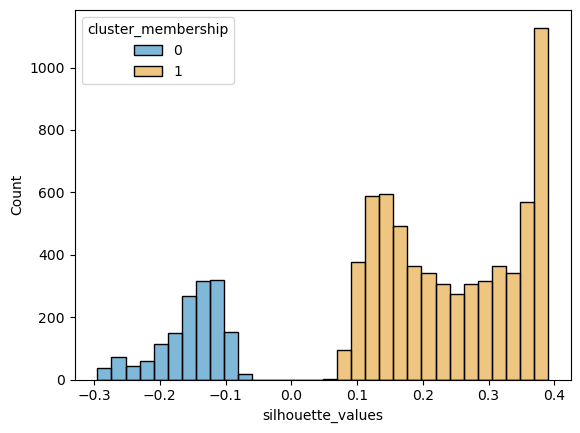

In [192]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [193]:
score=silhouette_score(mle_distance_matrix, mle_kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.17093427614669576


In [194]:
mle_kp.cluster_centroids_.shape

(2, 1603)

In [195]:
print(mle_X.shape)
mle_X.head()

(8000, 1603)


,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
index,,,,,,,,,,,,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,19,3,1.201175,0.394703,-0.819090,-1.661411,...,0.093636,0.446063,0.239666,-0.002646,-0.637975,-0.174067,-0.880152,0.993532,-0.216550,0.245487
10795,0.112351,0.488889,0.001137,0,21,3,0.914265,-1.460022,1.231641,0.308616,...,-0.075058,0.009479,0.245371,0.036637,-0.025575,-0.039739,0.070507,-0.080255,-0.028007,0.096117
8239,0.070916,0.777778,0.000213,0,19,3,1.411847,-0.250859,1.285492,-2.084359,...,-0.110928,-0.135218,0.008501,0.032479,-0.311243,-0.607447,-0.035790,-0.061408,0.025087,-0.392126
14258,0.070120,0.633333,0.006323,0,14,3,0.516220,0.549301,-0.959559,-0.133562,...,-0.452931,-1.638832,1.144008,-0.150750,0.379856,0.036221,0.338750,0.939054,-0.059073,-0.168450
14059,0.073307,0.477778,0.000497,0,48,3,1.368371,0.309210,-0.285194,0.611423,...,-0.062228,0.057695,-0.165154,0.063427,-0.000079,0.116737,0.366404,-0.225131,0.172220,-0.233006


In [201]:
mle_kp.cluster_centroids_.shape

(2, 1603)

In [206]:
centroid_df = pd.DataFrame(mle_kp.cluster_centroids_, columns = mle_X.columns)
centroid_df.head()

,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
0,0.081326,0.562280,0.021565,0.021261,0.082059,-0.015882,0.024295,0.044866,0.142672,-0.027644,...,0.031035,0.059464,0.070050,-0.015315,-0.024247,-0.022010,0.001313,0.0,14.0,3.0
1,0.079479,0.555173,0.016197,-0.005089,-0.019641,0.003801,-0.005815,-0.010739,-0.034148,0.006617,...,-0.007428,-0.014233,-0.016767,0.003666,0.005803,0.005268,-0.000314,0.0,14.0,3.0


In [207]:
centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [208]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
0,103.064078,6.060518,303.527508,0.021261,0.082059,-0.015882,0.024295,0.044866,0.142672,-0.027644,...,0.031035,0.059464,0.070050,-0.015315,-0.024247,-0.022010,0.001313,0.0,14.0,3.0
1,100.745933,5.996561,227.965918,-0.005089,-0.019641,0.003801,-0.005815,-0.010739,-0.034148,0.006617,...,-0.007428,-0.014233,-0.016767,0.003666,0.005803,0.005268,-0.000314,0.0,14.0,3.0


In [209]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [210]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,component_0,component_1,component_2,component_3,...,component_1587,component_1588,component_1589,component_1590,component_1591,component_1592,component_1593,component_1594,component_1595,component_1596
0,103.064078,6.060518,303.527508,0,ab,In Production,0.024295,0.044866,0.142672,-0.027644,...,0.031035,0.059464,0.070050,-0.015315,-0.024247,-0.022010,0.001313,0.0,14.0,3.0
1,100.745933,5.996561,227.965918,0,ab,In Production,-0.005815,-0.010739,-0.034148,0.006617,...,-0.007428,-0.014233,-0.016767,0.003666,0.005803,0.005268,-0.000314,0.0,14.0,3.0


It would seem that the components obtained through PCA ended up taking protagonism, minimizing the participation of the other numerical and categorical variables.

In [211]:
# We save the results in the original dataframe

movies_metadata['membership_2_mle'] = mle_kp.labels_

#### 3.3.2 Evaluation using the size heuristic for components

In [212]:
heur_distance_matrix = squareform(heur_distance_matrix_cat*heuristic_kp.gamma + heur_distance_matrix_num)

In [213]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(heur_distance_matrix, heuristic_kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = heuristic_kp.labels_

silhouette_df.head()

,silhouette_values,cluster_membership
0,-0.142606,1
1,0.307792,0
2,0.241822,0
3,0.152685,0
4,0.215327,0


c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\manue\miniconda3\envs\ExtendedKproto\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='silhouette_values', ylabel='Count'>

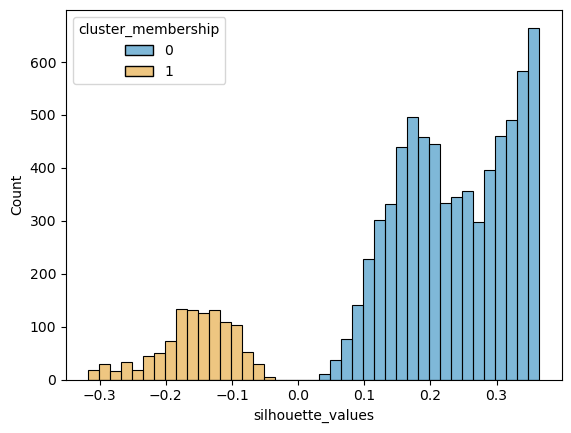

In [214]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [215]:
score=silhouette_score(heur_distance_matrix, heuristic_kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.18387829849022774


In [216]:
centroid_df = pd.DataFrame(heuristic_kp.cluster_centroids_, columns = list(heur_X.columns[num_col_indexes])+list(heur_X.columns[cat_col_indexes]))
centroid_df.head()

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,0.078794,0.552949,0.014881,-0.004907,-0.015320,0.022958,-0.026345,0.026272,-0.050422,-0.007177,...,-0.001099,-0.010270,0.013290,0.005411,0.008317,-0.005337,0.000078,0.0,14.0,3.0
1,0.086313,0.578921,0.031868,0.030525,0.095297,-0.142805,0.163875,-0.163419,0.313633,0.044644,...,0.006834,0.063881,-0.082668,-0.033655,-0.051732,0.033200,-0.000485,0.0,14.0,3.0


In [217]:
centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [218]:
centroid_df

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,99.886825,5.976538,209.444138,-0.004907,-0.015320,0.022958,-0.026345,0.026272,-0.050422,-0.007177,...,-0.001099,-0.010270,0.013290,0.005411,0.008317,-0.005337,0.000078,0.0,14.0,3.0
1,109.322202,6.210289,448.538809,0.030525,0.095297,-0.142805,0.163875,-0.163419,0.313633,0.044644,...,0.006834,0.063881,-0.082668,-0.033655,-0.051732,0.033200,-0.000485,0.0,14.0,3.0


It would seem that the lower amount of components has helped retain the importance of vote_count in differentiating the clusters, but the categorical variables remain as low contributors with the current value of gamma.

In [219]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [220]:
centroid_df

,runtime,vote_average,vote_count,component_0,component_1,component_2,component_3,component_4,component_5,component_6,...,component_393,component_394,component_395,component_396,component_397,component_398,component_399,adult,original_language,status
0,99.886825,5.976538,209.444138,-0.004907,-0.015320,0.022958,-0.026345,0.026272,-0.050422,-0.007177,...,-0.001099,-0.010270,0.013290,0.005411,0.008317,-0.005337,0.000078,0,en,Released
1,109.322202,6.210289,448.538809,0.030525,0.095297,-0.142805,0.163875,-0.163419,0.313633,0.044644,...,0.006834,0.063881,-0.082668,-0.033655,-0.051732,0.033200,-0.000485,0,en,Released


Non-Adult, English and Released movies. Adding the information in the multi-valued categorical attributes into the numeric component of the sum of distances has led to the gamma being too low for the categorical elements to influence the clustering.

In [221]:
# We save the results in the original dataframe

movies_metadata['membership_2_heur'] = heuristic_kp.labels_

Done!

## Option 4: Apply the extended K-Prototypes.

In [6]:
# option_4_df = movies_metadata.copy()

NameError: name 'movies_metadata' is not defined

In [223]:
# option_4_df.index.rename('index', inplace=True)

# option_4_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,membership_1,membership_2,membership_2_mle,membership_2_heur
index,,,,,,,,,,,,,,,,
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629,0,1,1,1
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137,1,1,1,0
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213,0,1,1,0
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323,0,1,1,0
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497,0,1,1,0


In [235]:
# option_4_df.to_pickle('option4.pkl')

### Load the Data

In [7]:
option_4_df = pd.read_pickle('option4.pkl')
option_4_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,membership_1,membership_2,membership_2_mle,membership_2_heur
index,,,,,,,,,,,,,,,,
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629,0,1,1,1
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137,1,1,1,0
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213,0,1,1,0
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323,0,1,1,0
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497,0,1,1,0


In [8]:
num_cols = ['runtime', 'vote_average', 'vote_count']
cat_cols = ['adult', 'original_language', 'status']
multi_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

In [9]:
print(num_cols)
print(cat_cols)
print(multi_cols)

['runtime', 'vote_average', 'vote_count']
['adult', 'original_language', 'status']
['genres', 'production_companies', 'production_countries', 'spoken_languages']


In [10]:
X = option_4_df.loc[:, num_cols+cat_cols+multi_cols]

In [11]:
X.head()

,runtime,vote_average,vote_count,adult,original_language,status,genres,production_companies,production_countries,spoken_languages
index,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,fr,Released,"[History, Drama]",[83],"[FR, IT]","[af, nl, en, fr]"
10795,0.112351,0.488889,0.001137,0,hi,Released,[Comedy],[3939],[IN],[hi]
8239,0.070916,0.777778,0.000213,0,fr,Released,[Documentary],[6841],"[CH, FR, DE]",[fr]
14258,0.070120,0.633333,0.006323,0,en,Released,[Drama],"[288, 7281, 64479, 74150, 92473, 92474]",[GB],[en]
14059,0.073307,0.477778,0.000497,0,pt,Released,[Drama],"[8680, 16418, 26019]",[PT],[pt]


Let's prepare the data now.

### 4.1 Data Preparation

In [12]:
X_num = X[num_cols]
X_cat = X[cat_cols]
X_multi = X[multi_cols]

#### 4.1.1 Numerical Attributes

In [13]:
# Already scaled at the top section. 

# numerical_scaler = MinMaxScaler()

# X_num = pd.DataFrame(numerical_scaler.fit_transform(X_num.values),
#                      columns=X_num.columns,
#                      index=X_num.index)

In [14]:
X_num.head()

,runtime,vote_average,vote_count
index,,,
8968,0.125896,0.666667,0.002629
10795,0.112351,0.488889,0.001137
8239,0.070916,0.777778,0.000213
14258,0.070120,0.633333,0.006323
14059,0.073307,0.477778,0.000497


Done!

#### 4.1.2 Categorical Attributes

In [15]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat[col] = cat_enc.fit_transform(X.loc[:,col])

    cat_encoders[col] = cat_enc

C:\Users\manue\AppData\Local\Temp\ipykernel_13172\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_13172\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = cat_enc.fit_transform(X.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_13172\541158656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [16]:
X_cat.head()

,adult,original_language,status
index,,,
8968,0,19,3
10795,0,21,3
8239,0,19,3
14258,0,14,3
14059,0,48,3


Done!

#### 4.1.3 Multi-valued attributes/dummies

In [17]:
X_multi = X_multi.map(set)

X_multi.head()

,genres,production_companies,production_countries,spoken_languages
index,,,,
8968,"{Drama, History}",{83},"{FR, IT}","{nl, af, fr, en}"
10795,{Comedy},{3939},{IN},{hi}
8239,{Documentary},{6841},"{CH, FR, DE}",{fr}
14258,{Drama},"{74150, 7281, 92474, 92473, 288, 64479}",{GB},{en}
14059,{Drama},"{26019, 16418, 8680}",{PT},{pt}


Done!

### 4.2 Clustering

In [18]:
joint_X = pd.concat((X_num, X_cat, X_multi), axis=1)

print(joint_X.shape)

joint_X.head()

(8000, 10)


,runtime,vote_average,vote_count,adult,original_language,status,genres,production_companies,production_countries,spoken_languages
index,,,,,,,,,,
8968,0.125896,0.666667,0.002629,0,19,3,"{Drama, History}",{83},"{FR, IT}","{nl, af, fr, en}"
10795,0.112351,0.488889,0.001137,0,21,3,{Comedy},{3939},{IN},{hi}
8239,0.070916,0.777778,0.000213,0,19,3,{Documentary},{6841},"{CH, FR, DE}",{fr}
14258,0.070120,0.633333,0.006323,0,14,3,{Drama},"{74150, 7281, 92474, 92473, 288, 64479}",{GB},{en}
14059,0.073307,0.477778,0.000497,0,48,3,{Drama},"{26019, 16418, 8680}",{PT},{pt}


#### 4.2.1 EXPERIMENTS - DISTANCE FUNCTION AND INITIALISATION

In [19]:
X_multi.values[0]

array([{'Drama', 'History'}, {'83'}, {'FR', 'IT'},
       {'nl', 'af', 'fr', 'en'}], dtype=object)

In [20]:
X_multi.values[:10]

array([[{'Drama', 'History'}, {'83'}, {'FR', 'IT'},
        {'nl', 'af', 'fr', 'en'}],
       [{'Comedy'}, {'3939'}, {'IN'}, {'hi'}],
       [{'Documentary'}, {'6841'}, {'CH', 'FR', 'DE'}, {'fr'}],
       [{'Drama'}, {'74150', '7281', '92474', '92473', '288', '64479'},
        {'GB'}, {'en'}],
       [{'Drama'}, {'26019', '16418', '8680'}, {'PT'}, {'pt'}],
       [{'Drama', 'Comedy'}, {'5353'}, {'IE', 'SE'}, {'sv'}],
       [{'Documentary'}, {'52082'}, {'US'}, {'en'}],
       [{'Drama'}, {'2361', '43', '10059', '23105', '67504'}, {'US'},
        {'en'}],
       [{'Music', 'Drama', 'Documentary', 'Romance'}, {'3004'}, {'US'},
        {'en'}],
       [{'Drama', 'Thriller', 'Romance'}, {'1422'}, {'US'}, {'en'}]],
      dtype=object)

In [21]:
from kmodes.util.dissim import jaccard_dissim_sets

squareform(pdist(X_multi.values[:100], jaccard_dissim_sets))

array([[0.  , 4.  , 3.5 , ..., 3.75, 3.25, 3.75],
       [4.  , 0.  , 4.  , ..., 4.  , 4.  , 4.  ],
       [3.5 , 4.  , 0.  , ..., 4.  , 4.  , 4.  ],
       ...,
       [3.75, 4.  , 4.  , ..., 0.  , 2.  , 2.  ],
       [3.25, 4.  , 4.  , ..., 2.  , 0.  , 2.  ],
       [3.75, 4.  , 4.  , ..., 2.  , 2.  , 0.  ]])

In [22]:
distance_matrix_num = pdist(X_num[:1000].values)
distance_matrix_cat = pdist(X_cat[:1000].values, 'hamming')

In [23]:
distance_matrix_multi = pdist(X_multi[:1000].values, jaccard_dissim_sets)

The absence of a fast, C-based underlying function makes the process much slower compared to the distance matrix calculation for the numerical and categorical variables.

In [24]:
squareform(distance_matrix_multi)

array([[0.        , 4.        , 3.5       , ..., 3.3       , 3.41666667,
        3.5       ],
       [4.        , 0.        , 4.        , ..., 4.        , 4.        ,
        3.75      ],
       [3.5       , 4.        , 0.        , ..., 4.        , 4.        ,
        3.5       ],
       ...,
       [3.3       , 4.        , 4.        , ..., 0.        , 2.5       ,
        3.66666667],
       [3.41666667, 4.        , 4.        , ..., 2.5       , 0.        ,
        3.        ],
       [3.5       , 3.75      , 3.5       , ..., 3.66666667, 3.        ,
        0.        ]])

In [25]:
from kmodes.util.init_methods import init_cao_multi

In [26]:
# Set up
n_points, n_attrs = X_multi.shape
# centroids = np.empty((n_clusters, n_attrs), dtype='object')

# Create a dictionary of frequencies for each attribute
# OLD: Assumed X_multi was a pd.Dataframe
# flat_x = X_multi.map(np.array).values.flatten('F')

In [27]:
flat_x = np.array(list(map(lambda x: np.array(x, dtype='object'), X_multi.values))).flatten('F')

In [28]:
flat_x

array([{'Drama', 'History'}, {'Comedy'}, {'Documentary'}, ..., {'en'},
       {'ja', 'en'}, {'en'}], dtype=object)

In [29]:
start_idx = 0
attr_densities = []
attr_dict = defaultdict(default_factory=0)

for end_idx in range(n_points, flat_x.shape[0]+1, n_points):
        # Clear the dictionary from the previous iteration
        attr_dict.clear()
        # Select the relevant indices
        attr_values = flat_x[start_idx:end_idx]
        start_idx = end_idx
        # Turn the sets into lists for everything else to work
        attr_values = list(map(list, attr_values))
        # Extract a dictionary for each attribute
        keys, values = np.unique(np.concatenate(attr_values), return_counts=True)
        attr_dict.update(zip(keys, values))
        
        # For each observation, reference the dict to get the total hits
        element_counts = list(
            map(np.vectorize(lambda x: attr_dict[x]), attr_values)
            )
        totals = np.array(
            [np.sum(observation) for observation in element_counts]
            )
        n_unique_vals = len(attr_dict.keys())
        attr_densities.append(totals / n_unique_vals)
dens = np.sum(np.column_stack(attr_densities), axis=1) / n_attrs

In [30]:
dens = np.sum(np.column_stack(attr_densities), axis=1) / n_attrs

In [31]:
n_clusters = 3

In [32]:
centroids = np.empty((n_clusters, n_attrs), dtype='object')
centroids[0] = X_multi.values[np.argmax(dens)]

chosen_indexes = [np.argmax(dens)]

In [33]:
centroids

array([[{'Adventure', 'Thriller', 'Romance', 'Fantasy', 'Action', 'Comedy', 'Drama'},
        {'5730', '3241', '19528'}, {'US'},
        {'pt', 'mn', 'la', 'fr', 'en'}],
       [None, None, None, None],
       [None, None, None, None]], dtype=object)

In [34]:
from kmodes.util.dissim import matching_dissim, jaccard_dissim_sets

matching_dissim(X_multi.values, centroids[0]).shape

(8000,)

In [35]:
jaccard_dissim_sets(X_multi.values, centroids[0]).shape

(8000,)

In [36]:
jaccard_dissim_sets(X_multi.values, centroids[0])

array([3.58928571, 3.85714286, 3.8       , ..., 2.55      , 3.83333333,
       2.675     ])

In [37]:
jaccard_dissim_sets(centroids[0], centroids[0])

0.0

In [38]:
dens

array([71.45689573, 31.46028214, 12.8488449 , ..., 77.09723726,
       28.19944523, 78.61871649])

In [39]:
np.argmax(jaccard_dissim_sets(X_multi.values, centroids[0]) * dens)

6845

In [40]:
# For the remaining centroids, choose maximum dens * dissim to the
# (already assigned) centroid with the lowest dens * dissim.
for ik in range(1, n_clusters):
    dd = np.empty((ik, n_points))
    for ikk in range(ik):
        dd[ikk] = jaccard_dissim_sets(X_multi.values, centroids[ikk]) * dens
    chosen_index = np.argmax(np.min(dd, axis=0))
    centroids[ik] = X_multi.values[chosen_index]
    chosen_indexes.append(chosen_index)

In [41]:
centroids

array([[{'Adventure', 'Thriller', 'Romance', 'Fantasy', 'Action', 'Comedy', 'Drama'},
        {'5730', '3241', '19528'}, {'US'},
        {'pt', 'mn', 'la', 'fr', 'en'}],
       [{'Drama', 'Romance', 'Action', 'Comedy', 'Crime', 'Mystery'},
        {'16486', '53044', '3488', '5267', '53043', '2452'},
        {'IE', 'GB'}, {'en'}],
       [{'Thriller', 'Romance', 'Action', 'Foreign', 'Comedy', 'Drama'},
        {'1059'}, {'IT', 'FR', 'DE'}, {'fr'}]], dtype=object)

In [42]:
chosen_indexes

[1778, 6845, 2081]

Put everything together now:

In [43]:
init_cao_multi(X_multi.values, n_clusters, jaccard_dissim_sets)

array([[{'Adventure', 'Thriller', 'Romance', 'Fantasy', 'Action', 'Comedy', 'Drama'},
        {'5730', '3241', '19528'}, {'US'},
        {'pt', 'mn', 'la', 'fr', 'en'}],
       [{'Drama', 'Romance', 'Action', 'Comedy', 'Crime', 'Mystery'},
        {'16486', '53044', '3488', '5267', '53043', '2452'},
        {'IE', 'GB'}, {'en'}],
       [{'Thriller', 'Romance', 'Action', 'Foreign', 'Comedy', 'Drama'},
        {'1059'}, {'IT', 'FR', 'DE'}, {'fr'}]], dtype=object)

Now get the centroids for the numerical and categorical variables as well.

In [44]:
from kmodes.util.init_methods import init_cao, init_huang
from kmodes.util.dissim import matching_dissim, euclidean_dissim

In [45]:
centroids = init_cao(X_cat.values, n_clusters, matching_dissim)

In [46]:
from sklearn.utils import check_random_state

random_state = check_random_state(42)

In [47]:
meanx = np.mean(X_num.values, axis=0)
stdx = np.std(X_num.values, axis=0)
nnumattrs = X_num.shape[1]

centroids = [
    meanx + random_state.randn(n_clusters, nnumattrs) * stdx,
    centroids,
    init_cao_multi(X_multi.values, n_clusters, jaccard_dissim_sets)
]

In [48]:
centroids

[array([[ 0.0918075 ,  0.53909426,  0.05310679],
        [ 0.11654404,  0.52699124,  0.00426517],
        [ 0.11789817,  0.65341065, -0.00876945]]),
 array([[0, 14, 3],
        [0, 19, 4],
        [0, 28, 1]], dtype=object),
 array([[{'Adventure', 'Thriller', 'Romance', 'Fantasy', 'Action', 'Comedy', 'Drama'},
         {'5730', '3241', '19528'}, {'US'},
         {'pt', 'mn', 'la', 'fr', 'en'}],
        [{'Drama', 'Romance', 'Action', 'Comedy', 'Crime', 'Mystery'},
         {'16486', '53044', '3488', '5267', '53043', '2452'},
         {'IE', 'GB'}, {'en'}],
        [{'Thriller', 'Romance', 'Action', 'Foreign', 'Comedy', 'Drama'},
         {'1059'}, {'IT', 'FR', 'DE'}, {'fr'}]], dtype=object)]

In [49]:
all(
    (
    centroids[0].shape == (n_clusters, X_num.shape[1]),
    centroids[1].shape == (n_clusters, X_cat.shape[1]),
    centroids[2].shape == (n_clusters, X_multi.shape[1]),
    )
)

True

Done!

#### 4.2.2 EXPERIMENTS - CLUSTERING

##### Split the Input Data by Attribute Type

In [50]:
def _split_num_cat_multi(x, cat_idxs, multi_val_idxs):
    """Extract numerical and categorical columns.
    Convert to numpy arrays, if needed.

    :param x: Feature matrix
    :param categorical: Indices of categorical columns
    """
    num_idxs = [i for i in range(x.shape[1]) 
                if i not in (cat_idxs + multi_val_idxs)]
    Xnum = np.asanyarray(x[:, num_idxs]).astype(np.float64)
    
    Xcat = np.asanyarray(x[:, cat_idxs])
    Xmulti = np.asanyarray(x[:, multi_val_idxs])
    return Xnum, Xcat, Xmulti

In [51]:
categorical_idxs = [3, 4, 5]
multi_valued_idxs = [6, 7, 8, 9]

In [52]:
Xnum, Xcat, Xmulti = _split_num_cat_multi(joint_X.values, cat_idxs=categorical_idxs, multi_val_idxs=multi_valued_idxs)

Done!

##### Centroid Initialisation and First Cluster Assignment Loop

In [53]:
gamma_c = 0.33
gamma_m = 0.33

num_dissim = euclidean_dissim
cat_dissim = matching_dissim
multi_dissim = jaccard_dissim_sets
sample_weight = None

init = 'cao'

In [54]:
gamma_n = 1 - (gamma_c + gamma_m)
nnumattrs = Xnum.shape[1]
ncatattrs = Xcat.shape[1]
nmultiattrs = Xmulti.shape[1]

random_state = check_random_state(random_state)
init_tries = 0

# CENTROID INIT AND FIRST CLUSTER ASSINGMENT LOOP --------
while True:
    init_tries += 1
    # _____ INIT _____
    if verbose:
        print("Init: initializing centroids")
    if isinstance(init, str) and init.lower() == 'huang':
        centroids = init_huang(Xcat, n_clusters, cat_dissim, random_state)
    elif isinstance(init, str) and init.lower() == 'cao':
        centroids = init_cao(Xcat, n_clusters, cat_dissim)
    elif isinstance(init, str) and init.lower() == 'random':
        seeds = random_state.choice(range(n_points), n_clusters)
        centroids = Xcat[seeds]
    elif isinstance(init, list):
        # Make sure inits are 2D arrays.
        init = [np.atleast_2d(cur_init).T if len(cur_init.shape) == 1
                else cur_init
                for cur_init in init]
        assert init[0].shape[0] == n_clusters, \
            "Wrong number of initial numerical centroids in init " \
            f"({init[0].shape[0]}, should be {n_clusters})."
        assert init[0].shape[1] == nnumattrs, \
            "Wrong number of numerical attributes in init " \
            f"({init[0].shape[1]}, should be {nnumattrs})."
        assert init[1].shape[0] == n_clusters, \
            "Wrong number of initial categorical centroids in init " \
            f"({init[1].shape[0]}, should be {n_clusters})."
        assert init[1].shape[1] == ncatattrs, \
            "Wrong number of categorical attributes in init " \
            f"({init[1].shape[1]}, should be {ncatattrs})."
        centroids = [np.asarray(init[0], dtype=np.float64),
                        np.asarray(init[1], dtype=np.uint16)]
    else:
        raise NotImplementedError("Initialization method not supported.")

    if not isinstance(init, list):
        # Numerical is initialized by drawing from normal distribution,
        # categorical following the k-modes methods.
        meanx = np.mean(Xnum, axis=0)
        stdx = np.std(Xnum, axis=0)
        centroids = [   # 0:num, 1:cat, 2:multi
            meanx + random_state.randn(n_clusters, nnumattrs) * stdx,
            centroids,
            # Add multi-categorical part
            init_cao_multi(Xmulti, n_clusters=n_clusters,
                            dissim=multi_dissim)
        ]

    # INITIAL CLUSTER ASSIGNMENT ------
    if verbose:
        print("Init: initializing clusters")
    membship = np.zeros((n_clusters, n_points), dtype=np.bool_)
    # Keep track of the sum of attribute values per cluster so that we
    # can do k-means on the numerical attributes.
    cl_attr_sum = np.zeros((n_clusters, nnumattrs), dtype=np.float64)
    # Same for the membership sum per cluster
    cl_memb_sum = np.zeros(n_clusters, dtype=np.float64)
    # cl_attr_freq is a list of lists with dictionaries that contain
    # the frequencies of values per cluster and attribute.
    cl_attr_freq = [[defaultdict(float) for _ in range(ncatattrs)]
                    for _ in range(n_clusters)]

    # Go point by point to fill these "accounting" matrices and dicts
    for ipoint in range(n_points):
        weight = sample_weight[ipoint] if sample_weight is not None else 1
        # Initial assignment to clusters
        clust = np.argmin(
            gamma_n * num_dissim(centroids[0], Xnum[ipoint]) +
            gamma_c * cat_dissim(
                centroids[1], Xcat[ipoint], X=Xcat, membship=membship) +
            gamma_m * multi_dissim(centroids[2], Xmulti[ipoint])
        )
        membship[clust, ipoint] = 1
        cl_memb_sum[clust] += weight
        # Count attribute values per cluster.
        for iattr, curattr in enumerate(Xnum[ipoint]):
            cl_attr_sum[clust, iattr] += curattr * weight
        for iattr, curattr in enumerate(Xcat[ipoint]):
            cl_attr_freq[clust][iattr][curattr] += weight

    # If no empty clusters, then consider initialization finalized.
    if membship.sum(axis=1).min() > 0:
        break

    if init_tries == MAX_INIT_TRIES:
        # Could not get rid of empty clusters. Randomly
        # initialize instead.
        init = 'random'
    elif init_tries == RAISE_INIT_TRIES:
        raise ValueError(
            "Clustering algorithm could not initialize. "
            "Consider assigning the initial clusters manually."
        )

Init: initializing centroids
Init: initializing clusters


In [55]:
centroids

[array([[ 0.09291249,  0.49805373, -0.00856204],
        [ 0.0856674 ,  0.31505359, -0.07830462],
        [ 0.06628315,  0.42870734,  0.0346385 ]]),
 array([[0, 14, 3],
        [0, 19, 4],
        [0, 28, 1]], dtype=object),
 array([[{'Adventure', 'Thriller', 'Romance', 'Fantasy', 'Action', 'Comedy', 'Drama'},
         {'5730', '3241', '19528'}, {'US'},
         {'pt', 'mn', 'la', 'fr', 'en'}],
        [{'Drama', 'Romance', 'Action', 'Comedy', 'Crime', 'Mystery'},
         {'16486', '53044', '3488', '5267', '53043', '2452'},
         {'IE', 'GB'}, {'en'}],
        [{'Thriller', 'Romance', 'Action', 'Foreign', 'Comedy', 'Drama'},
         {'1059'}, {'IT', 'FR', 'DE'}, {'fr'}]], dtype=object)]

In [56]:
cl_attr_sum.shape

(3, 3)

In [57]:
len(cl_attr_freq)

3

In [58]:
len(cl_attr_freq[1])

3

In [59]:
cl_memb_sum.shape

(3,)

In [60]:
membship.shape

(3, 8000)

Done!

##### Initial Centroid Update

In [61]:
# An extension of the Kmodes clustering logic

In [62]:
Xmulti

array([[{'Drama', 'History'}, {'83'}, {'FR', 'IT'},
        {'nl', 'af', 'fr', 'en'}],
       [{'Comedy'}, {'3939'}, {'IN'}, {'hi'}],
       [{'Documentary'}, {'6841'}, {'CH', 'FR', 'DE'}, {'fr'}],
       ...,
       [{'Action', 'Family', 'Comedy'},
        {'46222', '7431', '3045', '2608', '34034', '5'}, {'US'}, {'en'}],
       [{'Family', 'Animation'},
        {'Hokkaido Broadcasting Co.', '7092', '7094'}, {'JP'},
        {'ja', 'en'}],
       [{'Drama', 'Family'}, {'5200'}, {'US'}, {'en'}]], dtype=object)

In [63]:
from kmodes.util.init_methods import count_dictionary_value_frequency

count_dictionary_value_frequency(Xmulti, n_points)

[array([212.05, 122.3 ,  29.1 , ..., 220.6 ,  52.6 , 226.7 ]),
 array([0.00526849, 0.00010132, 0.00020263, ..., 0.01428571, 0.00070922,
        0.00020263]),
 array([ 9.35483871,  1.82258065, 12.79032258, ..., 33.62903226,
         2.60483871, 33.62903226]),
 array([64.41747573,  1.7184466 ,  9.50485437, ..., 54.14563107,
        57.59223301, 54.14563107])]

This one has the counts divided by the length of the dictionary.

In [64]:
cl_multi_attr_freq = [[defaultdict(float) for _ in range(Xmulti.shape[1])]
                     for _ in range(n_clusters)]

cl_multi_attr_freq

[[defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {})],
 [defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {})],
 [defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {}),
  defaultdict(float, {})]]

In [65]:
# Make a global recount of attribute value frequencies
if verbose:
        print("Init: initializing clusters")
membship = np.zeros((n_clusters, n_points), dtype=np.bool_)
# Keep track of the sum of attribute values per cluster so that we
# can do k-means on the numerical attributes.
cl_attr_sum = np.zeros((n_clusters, nnumattrs), dtype=np.float64)
# Same for the membership sum per cluster
cl_memb_sum = np.zeros(n_clusters, dtype=np.float64)
# cl_attr_freq is a list of lists with dictionaries that contain
# the frequencies of values per cluster and attribute.
cl_attr_freq = [[defaultdict(float) for _ in range(ncatattrs)]
                for _ in range(n_clusters)]

cl_multi_attr_freq = [[defaultdict(float) for _ in range(Xmulti.shape[1])]
                    for _ in range(n_clusters)]
gl_multi_attr_freq = [defaultdict(float) for _ in range(Xmulti.shape[1])]

Init: initializing clusters


In [66]:
# Go point by point to fill these "accounting" matrices and dicts
for ipoint in range(n_points):
    weight = sample_weight[ipoint] if sample_weight is not None else 1
    # Initial assignment to clusters
    clust = np.argmin(
        gamma_n * num_dissim(centroids[0], Xnum[ipoint]) +
        gamma_c * cat_dissim(
            centroids[1], Xcat[ipoint], X=Xcat, membship=membship) +
        gamma_m * multi_dissim(centroids[2], Xmulti[ipoint])
    )
    membship[clust, ipoint] = 1
    cl_memb_sum[clust] += weight
    # Count attribute values per cluster.
    for iattr, curattr in enumerate(Xnum[ipoint]):
        cl_attr_sum[clust, iattr] += curattr * weight
    for iattr, curattr in enumerate(Xcat[ipoint]):
        cl_attr_freq[clust][iattr][curattr] += weight
    for iattr, curattr in enumerate(Xmulti[ipoint]):
        # curattr is a set in this case
        for item in curattr:
            gl_multi_attr_freq[iattr][item] += weight
            cl_multi_attr_freq[clust][iattr][item] += weight

# Second pass to normalize by cluster membership
# for iattr in range(Xmulti.shape[1]):
#     for ik in range(n_clusters):
#         for item in cl_multi_attr_freq[ik][iattr].keys():
#             cl_multi_attr_freq[ik][iattr][item] = \
#                 cl_multi_attr_freq[ik][iattr][item] / cl_memb_sum[ik]
#     # Do a similar pass through the global counts
#     for item in gl_multi_attr_freq[iattr].keys():
#         gl_multi_attr_freq[iattr][item] = \
#             gl_multi_attr_freq[iattr][item] / n_points

In [67]:
gl_multi_attr_freq[0]

defaultdict(float,
            {'Drama': 3959.0,
             'History': 282.0,
             'Comedy': 2446.0,
             'Documentary': 582.0,
             'Music': 231.0,
             'Romance': 1206.0,
             'Thriller': 1866.0,
             'Family': 575.0,
             'Mystery': 513.0,
             'Horror': 997.0,
             'Animation': 477.0,
             'Fantasy': 463.0,
             'Crime': 798.0,
             'War': 215.0,
             'Action': 1391.0,
             'Adventure': 736.0,
             'Science Fiction': 635.0,
             'TV Movie': 155.0,
             'Foreign': 216.0,
             'Western': 49.0})

In [68]:
cl_multi_attr_freq[0][0]

defaultdict(float,
            {'Drama': 3666.0,
             'History': 267.0,
             'Comedy': 2249.0,
             'Documentary': 571.0,
             'Music': 225.0,
             'Romance': 1111.0,
             'Thriller': 1794.0,
             'Family': 568.0,
             'Mystery': 491.0,
             'Horror': 962.0,
             'Animation': 452.0,
             'Fantasy': 457.0,
             'Crime': 758.0,
             'War': 204.0,
             'Action': 1328.0,
             'Adventure': 731.0,
             'Science Fiction': 611.0,
             'TV Movie': 153.0,
             'Foreign': 192.0,
             'Western': 49.0})

In [69]:
def compare_cl_to_gl_attribute_frequency(cl_dict, gl_dict, n_clust, n_points):
    modal_set = set()
    for item in cl_dict.keys():
        if item in gl_dict:
            freq_delta = (cl_dict[item])/n_clust - (gl_dict[item])/n_points
            if freq_delta >= 0.001:
                modal_set.add(item)
    
    return modal_set

In [70]:
compare_cl_to_gl_attribute_frequency(cl_dict = cl_multi_attr_freq[0][0],
                                     gl_dict = gl_multi_attr_freq[0],
                                     n_clust=cl_memb_sum[0],
                                     n_points=n_points)

{'Action',
 'Adventure',
 'Crime',
 'Documentary',
 'Family',
 'Fantasy',
 'Horror',
 'Music',
 'Mystery',
 'Science Fiction',
 'Thriller'}

In [71]:
from kmodes.util import get_max_value_key

In [72]:
# INITIAL CENTROID UPDATE
for ik in range(n_clusters):
    for iattr in range(nnumattrs):
        # Numerical update: mean of attributes
        centroids[0][ik, iattr] = cl_attr_sum[ik, iattr] / cl_memb_sum[ik]
    for iattr in range(ncatattrs):
        # Categorical update: mode of attributes
        centroids[1][ik, iattr] = get_max_value_key(cl_attr_freq[ik][iattr])
    for iattr in range(nmultiattrs):
        # Multi-valued update: proposed technique
        centroids[2][ik, iattr] = compare_cl_to_gl_attribute_frequency(
            cl_dict=cl_multi_attr_freq[ik][iattr],
            gl_dict=gl_multi_attr_freq[iattr],
            n_clust=cl_memb_sum[ik],
            n_points=n_points
        )

In [73]:
centroids[2]

array([[{'Adventure', 'Thriller', 'Family', 'Fantasy', 'Action', 'Music', 'Science Fiction', 'Horror', 'Crime', 'Mystery', 'Documentary'},
        {'33'},
        {'AU', 'DK', 'RU', 'ES', 'GB', 'IN', 'KR', 'CA', 'CN', 'US', 'DE', 'SE'},
        {'zh', 'ru', 'hi', 'pt', 'de', 'it', 'en', 'es', 'ko'}],
       [{'Romance', 'War', 'Action', 'History', 'Comedy', 'Mystery', 'Crime', 'Drama'},
        {'16486', '53044', 'Celluloid Dreams', '6301', '7777', '5381', '5106', '1992', '15066', '5666', '4061', '7272', '3659', '94', '5923', '24455', '12392', '844', '20897', '11199', '8092', '189', '8556', '6962', '22123', '32441', '104', '11247', '5267', '27127', '24457', '66335', '11239', '37343', '356', '7832', '38038', '28367', '7248', '33960', '21738', '10051', '11620', '2054', '23014', '23872', '1097', '32194', '10572', '1666', '865', '22997', '21741', '6194', '4348', '67264', '7382', '4394', '25484', '12046', '22770', '239', '2577', 'Fidélité Films', '31229', '37084', '67263', '20881', '31374',

Done!

##### Iterations of the Clustering Algorithm

Labels Cost

In [74]:
# from kmodes.extended_kprototypes import labels_cost
from sklearn.utils.validation import check_array

gamma_n = 1 - (gamma_c + gamma_m)
n_points = Xnum.shape[0]
Xnum = check_array(Xnum)

cost = 0.
labels = np.empty(n_points, dtype=np.uint16)
for ipoint in range(n_points):
    # Numerical cost = sum of Euclidean distances
    num_costs = num_dissim(centroids[0], Xnum[ipoint])
    cat_costs = cat_dissim(centroids[1], Xcat[ipoint], X=Xcat,
                            membship=membship)
    multi_costs = multi_dissim(centroids[2], Xmulti[ipoint])
    # Gamma relates the categorical cost to the numerical cost.
    tot_costs = (gamma_n * num_costs + 
                 gamma_c * cat_costs +
                 gamma_m * multi_costs)
    clust = np.argmin(tot_costs)
    labels[ipoint] = clust
    if sample_weight is not None:
        cost += tot_costs[clust] * sample_weight[ipoint]
    else:
        cost += tot_costs[clust]

In [75]:
labels

array([1, 2, 2, ..., 0, 2, 0], dtype=uint16)

In [76]:
cost

10281.920481179686

Done!

Section Analogous to `k_prototypes_iter`

In [96]:
gamma_n = 1 - (gamma_c + gamma_m)
moves = 0
for ipoint in range(Xnum.shape[0]):
    weight = sample_weight[ipoint] if sample_weight is not None else 1
    clust = np.argmin(
        gamma_n * num_dissim(centroids[0], Xnum[ipoint]) +
        gamma_c * cat_dissim(
            centroids[1], Xcat[ipoint], X=Xcat, membship=membship) +
        gamma_m * multi_dissim(centroids[2], Xmulti[ipoint])
    )
    if membship[clust, ipoint]:
        # Point is already in its right place.
        continue

    # Move point, and update old/new cluster frequencies and centroids.
    moves += 1
    old_clust = np.argwhere(membship[:, ipoint])[0][0]
    # DEBUG
    if old_clust != clust:
        break
    

In [97]:
# Beyond here, this is the iteration of the last point:

old_clust   # label of old cluster membership

0

In [99]:
clust       # label of new cluster membership

1

In [100]:
# _move_point_num
point = Xnum[ipoint]
to_clust = clust
from_clust = old_clust
weight = 1

# Update sum of attributes in cluster.
for iattr, curattr in enumerate(point):
    cl_attr_sum[to_clust][iattr] += curattr * weight
    cl_attr_sum[from_clust][iattr] -= curattr * weight
# Update sums of memberships in cluster
cl_memb_sum[to_clust] += 1
cl_memb_sum[from_clust] -= 1
# Does not change labels yet

In [110]:
# _move_point_multi
point = Xmulti[ipoint]
to_clust = clust
from_clust = old_clust
weight = 1

for iattr, curattr in enumerate(point):
    to_attr_counts = cl_multi_attr_freq[to_clust][iattr]
    from_attr_counts = cl_multi_attr_freq[from_clust][iattr]
    
    for item in list(curattr):
        to_attr_counts[item] += weight
        from_attr_counts[item] -= weight


In [ ]:
# We need to design the centroid updating logic

In [ ]:
# _move_point_cat

# Update cluster membership
membship[to_clust, ipoint] = 1
membship[from_clust, ipoint] = 0

# Update frequencies of attributes in cluster.
for iattr, curattr in enumerate(point):
    to_attr_counts = cl_attr_freq[to_clust][iattr]
    from_attr_counts = cl_attr_freq[from_clust][iattr]

    # Increment the attribute count for the new "to" cluster
    to_attr_counts[curattr] += sample_weight

    current_attribute_value_freq = to_attr_counts[curattr]
    current_centroid_value = centroids[to_clust][iattr]
    current_centroid_freq = to_attr_counts[current_centroid_value]
    if current_centroid_freq < current_attribute_value_freq:
        # We have incremented this value to the new mode. Update the centroid.
        centroids[to_clust][iattr] = curattr

    # Decrement the attribute count for the old "from" cluster
    from_attr_counts[curattr] -= sample_weight

    old_centroid_value = centroids[from_clust][iattr]
    if old_centroid_value == curattr:
        # We have just removed a count from the old centroid value. We need to
        # recalculate the centroid as it may no longer be the maximum
        centroids[from_clust][iattr] = get_max_value_key(from_attr_counts)

In [ ]:
# K-Prototype uses the squared euclidean to avoid the square root operation

# mle_distance_matrix_num = pdist(mle_X.iloc[:, num_col_indexes].values)
# mle_distance_matrix_cat = pdist(mle_X.iloc[:, cat_col_indexes].values, 'hamming')
# scores_dict = dict()

# for k in range(2, 6):
#     kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
#     labels = kp.fit_predict(mle_X, categorical=cat_col_indexes)
    
#     mle_distance_matrix = squareform(mle_distance_matrix_cat*kp.gamma + mle_distance_matrix_num)
#     score=silhouette_score(mle_distance_matrix, labels, metric="precomputed")
#     scores_dict[str(k)] = score

### 4.3 Evaluation